In [ ]:
import pandas as pd
df = pd.read_csv('final_table.csv')

# Convert order_date to datetime
df["order_date"] = pd.to_datetime(df["order_date"])

# Sort for correct lag computation
df = df.sort_values(by=["dc_ID", "region_ID", "order_date"]).reset_index(drop=True)

# Time-based features
df["day_of_week"] = df["order_date"].dt.dayofweek
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
df["day_of_month"] = df["order_date"].dt.day
df["is_start_of_month"] = (df["day_of_month"] <= 3).astype(int)
df["is_end_of_month"] = (df["day_of_month"] >= 29).astype(int)

# Lag and rolling features within each dc_ID and region_ID group
group_cols = ["dc_ID", "region_ID"]
df["lag_1_sales"] = df.groupby(group_cols)["daily_sales"].shift(1)
df["lag_2_sales"] = df.groupby(group_cols)["daily_sales"].shift(2)
df["lag_3_sales"] = df.groupby(group_cols)["daily_sales"].shift(3)
df["rolling_mean_3"] = df.groupby(group_cols)["daily_sales"].transform(lambda x: x.shift(1).rolling(3).mean())
df["rolling_std_3"] = df.groupby(group_cols)["daily_sales"].transform(lambda x: x.shift(1).rolling(3).std())
df["rolling_sum_7"] = df.groupby(group_cols)["daily_sales"].transform(lambda x: x.shift(1).rolling(7).sum())

# Add flags for missing lag/rolling values (Option B)
df["is_lagged_row"] = df["lag_1_sales"].isna().astype(int)
df["is_rolling_row"] = df["rolling_mean_3"].isna().astype(int)

In [ ]:
from sklearn.model_selection import train_test_split

# Define features and target
target = "daily_sales"

selected_features = [
    'lag_1_sales',
    'rolling_sum_7',
    'original_unit_price',
    'final_unit_price',
    'direct_discount',
    'quantity_discount',
    'coupon_discount',
    'bundle_discount',
    'lead_time',
    'availability',
    'day_of_week',
    'is_start_of_month',
    'is_end_of_month',
    'dc_ID',
    'region_ID',
    'lag_2_sales',
    'rolling_mean_3',
]

X = df[selected_features]
y = df[target]

# Perform random 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

MAE: 7.97
RMSE: 18.42
R² Score: 0.83


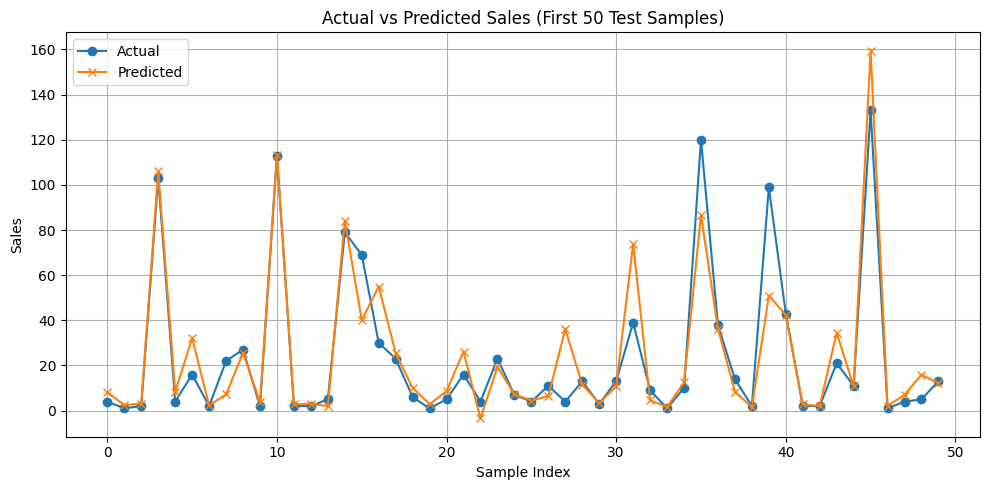

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Train the model
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Compare actual vs predicted visually
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:50], label='Actual', marker='o')
plt.plot(y_pred[:50], label='Predicted', marker='x')
plt.title("Actual vs Predicted Sales (First 50 Test Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

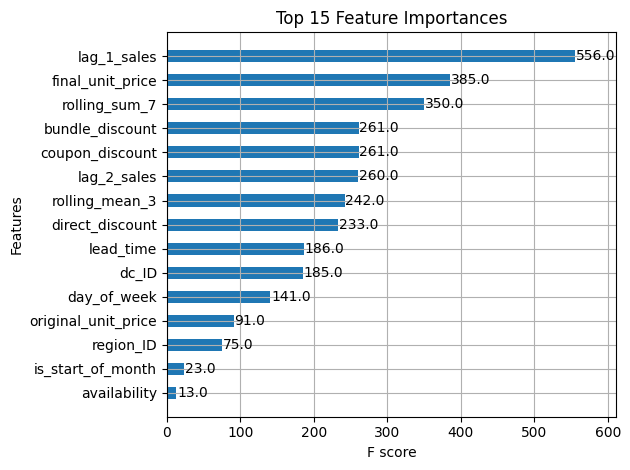

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importance
xgb.plot_importance(model, max_num_features=15, height=0.5)
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')

print(f"Mean MAE: {-scores.mean():.2f}, Std: {scores.std():.2f}")

Mean MAE: 8.21, Std: 0.99


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import xgboost as xgb

# Select just a few core features for validation
X_simple = X[['lag_1_sales', 'final_unit_price', 'lead_time']]
y_simple = y  # Same target: daily_sales

# Re-split the simplified data
X_simple_train, X_simple_test, y_simple_train, y_simple_test = train_test_split(
    X_simple, y_simple, test_size=0.2, random_state=42
)

# Train a basic XGBoost model
simple_model = xgb.XGBRegressor(random_state=42)
simple_model.fit(X_simple_train, y_simple_train)

# Predict and evaluate
y_simple_pred = simple_model.predict(X_simple_test)
r2_simple = r2_score(y_simple_test, y_simple_pred)

print(f"R² with only 3 features: {r2_simple:.3f}")


R² with only 3 features: 0.752
